- Mount Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

- Navigate to directory

In [2]:
# import os
# os.chdir('/content/drive/My Drive/Mortality-Prediction-MLP')

# Data preparation and processing

- Import libraries

In [3]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import numpy as np
import pandas as pd
import random

- Set a random seed to ensure the randomness is consistent

In [4]:
random.seed(42)
np.random.seed(42)

- Download dataset via kagglehub (Only run once)

In [5]:
# import kagglehub

# path = kagglehub.dataset_download("mitishaagarwal/patient")

# print("Path to dataset files:", path)

- Give a variable to store the path
- Read the CSV from the path
- Display the first 5 rows of data to test if successfully read the path

In [6]:
path = "/Users/soongjun/.cache/kagglehub/datasets/mitishaagarwal/patient/versions/3/dataset.csv"
# path = "/root/.cache/kagglehub/datasets/mitishaagarwal/patient/versions/3/dataset.csv"

data = pd.read_csv(path)

# data.head()

- Count the number of rows and columns
- Display the columns' names

In [7]:
print("Dataset shape:", data.shape, "\n")
print("Columns:", data.columns)

Dataset shape: (91713, 85) 

Columns: Index(['encounter_id', 'patient_id', 'hospital_id', 'age', 'bmi',
       'elective_surgery', 'ethnicity', 'gender', 'height', 'icu_admit_source',
       'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative',
       'arf_apache', 'gcs_eyes_apache', 'gcs_motor_apache',
       'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache',
       'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache',
       'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max',
       'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'd1_temp_max', 'd1_t

- Drop empty column by index
- Count the number of rows and columns to ensure the column is removed
- Display the new columns' names

In [8]:
data = data.drop(data.columns[-2], axis=1)
data = data.drop(columns = ["encounter_id", "hospital_id"])

print("Dataset shape:", data.shape, "\n")
print("Columns:", data.columns)

Dataset shape: (91713, 82) 

Columns: Index(['patient_id', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender',
       'height', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type',
       'pre_icu_los_days', 'weight', 'apache_2_diagnosis',
       'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache',
       'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache',
       'gcs_verbal_apache', 'heart_rate_apache', 'intubated_apache',
       'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache',
       'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
       'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max',
       'd1_temp_min', 'h1_diasbp_max', 'h1_

- Check the total columns with missing values

In [9]:
missing_values = data.isnull().mean() * 100

missing_summary = missing_values[missing_values > 0].sort_values(ascending=False)

print(f"Total columns with missing values: {missing_summary.shape[0]}")

Total columns with missing values: 74


- Separate the columns into numerical and categorical
- Handle missing values in numerical and categorical seperately
- Numerical will fill in missing values with medium values
- Categorical will fill in missing values with random choice from non-missing values
- Check if missing values is remained exist 

In [10]:
numerical_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(exclude=['number']).columns

for col in numerical_columns:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].median())

for col in categorical_columns:
    if data[col].isnull().sum() > 0:
        non_missing_values = data[col].dropna().unique()
        
        data[col] = data[col].apply(
            lambda x: np.random.choice(non_missing_values) if pd.isnull(x) else x
        )

missing_values_after_imputation = data.isnull().sum().sum()
print(f"Total missing values after imputation: {missing_values_after_imputation}")

Total missing values after imputation: 0


- Check the data types to identify categorical columns
- Apply one-hot Encoding to to categorical columns
- Count the number of rows and columns in the data

In [11]:
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

print("Categorical Columns:", categorical_columns, "\n")
# print("Data after one-hot encoding:", "\n")
# print(df_encoded.head(), "\n")
print("Shape after encoding:", data.shape)

Categorical Columns: ['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem'] 

Shape after encoding: (91713, 113)


- Separate the encoded data into X and y
- Split the data into training, validation, and testing set
- Data spliting ratio is 80:10:10
- Apply SMOTE after splitting

In [12]:
X = data.drop(columns=['hospital_death', 'patient_id'])
y = data['hospital_death']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Class distribution before SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:", Counter(y_train))

Class distribution before SMOTE: Counter({0: 67038, 1: 6332})


/Users/soongjun/Library/CloudStorage/OneDrive-UniversitiMalaya/myenv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/soongjun/Library/CloudStorage/OneDrive-UniversitiMalaya/myenv/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE: Counter({1: 67038, 0: 67038})


- Convert to numpy array in float data type
- Display if any null value

In [13]:
X_train = np.array(X_train, dtype=float)
X_validate = np.array(X_validate, dtype=float)
X_test = np.array(X_test, dtype=float)

print("Any null values in X_train:", np.isnan(X_train).any())
print("Any null values in X_validate:", np.isnan(X_validate).any())
print("Any null values in X_test:", np.isnan(X_test).any())

Any null values in X_train: False
Any null values in X_validate: False
Any null values in X_test: False


- Identify the numerical columns
- Apply feature scaling after SMOTE on numerical values
- Display the shape of datasets

In [14]:
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_indices = [X.columns.get_loc(col) for col in numerical_columns]

# print(len(numerical_columns))

scaler = StandardScaler()
X_train[:, numerical_indices] = scaler.fit_transform(X_train[:, numerical_indices])
X_validate[:, numerical_indices] = scaler.transform(X_validate[:, numerical_indices])
X_test[:, numerical_indices] = scaler.transform(X_test[:, numerical_indices])

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_validate.shape)
print("Test set shape:", X_test.shape)

Training set shape: (134076, 111)
Validation set shape: (9171, 111)
Test set shape: (9172, 111)


# Model Architecture

- Import external Python file which is the model architecture
- Import libraries 

In [15]:
from early_stopping import EarlyStopping
from hyperparameter_utils import sample_hyperparameters, train_and_evaluate
from model_utils import MLPModel
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

- Set a random seed to ensure the randomness is consistent

In [16]:
torch.manual_seed(42)

- Check if CUDA is available and set the device
- If CUDA is available then set the seeds

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cpu


- Convert data into numpy array

In [18]:
y_validate = y_validate.to_numpy()

- Convert data into Tensor array
- Assign variables for train and validate dataset
- Feed the data into DataLoader

In [19]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_validate_tensor = torch.tensor(X_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.float32).unsqueeze(1)

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_validate_tensor = X_validate_tensor.to(device)
y_validate_tensor = y_validate_tensor.to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(X_validate_tensor, y_validate_tensor)

- Apply Binary Cross Entropy Loss

In [20]:
criterion = nn.BCELoss()

- Initiate CUDA if available
- List of hyperparameter prepared to tune
- Set up number of trials to search the best hyperparameter
- Apply early stopping during training

In [21]:
param_space = {
    'hidden_layers': [[128, 64], [256, 128], [64, 32]],
    'dropout_rate': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64]
}

num_trials = 9
results = []

for _ in range(num_trials):
    params = sample_hyperparameters(param_space)
    validate_loss, params = train_and_evaluate(
        params=params,
        model_class=MLPModel,
        input_dim=X_train.shape[1],
        train_dataset=train_dataset,
        validate_dataset=validate_dataset,
        criterion=criterion,
        num_epochs=500
    )
    results.append((validate_loss, params))

results = sorted(results, key=lambda x: x[0])
print("Best Configuration:", results[0])

Testing configuration: {'hidden_layers': [64, 32], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
Early stopping triggered at epoch 50
Best Validation Loss for configuration {'hidden_layers': [64, 32], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}: 0.2319

Testing configuration: {'hidden_layers': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Early stopping triggered at epoch 102
Best Validation Loss for configuration {'hidden_layers': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}: 0.2311

Testing configuration: {'hidden_layers': [64, 32], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64}
Early stopping triggered at epoch 102
Best Validation Loss for configuration {'hidden_layers': [64, 32], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64}: 0.2323

Testing configuration: {'hidden_layers': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
Early stopp

- Combine the training data and validate data into one dataset
- Extract the best hyperparameter tuning list
- Train the model again with the best parameters
- Apply early stopping

In [22]:
best_result = min(results, key=lambda x: x[0])
best_params = best_result[1]

X_train_combined = torch.cat((X_train_tensor, X_validate_tensor), dim=0).to(device)
y_train_combined = torch.cat((y_train_tensor, y_validate_tensor), dim=0).to(device)

combined_dataset = TensorDataset(X_train_combined, y_train_combined)
combined_loader = DataLoader(combined_dataset, batch_size=best_params['batch_size'], shuffle=True)

model = MLPModel(
    input_dim=X_train_combined.shape[1],
    hidden_layers=best_params['hidden_layers'],
    dropout_rate=best_params['dropout_rate']
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])

early_stopping = EarlyStopping(patience=40, min_delta=0.0005)

train_losses = []
val_losses = []

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in combined_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(combined_loader)
    train_losses.append(train_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")

    early_stopping.check(train_loss)
    if early_stopping.should_stop:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

Epoch 10/500, Train Loss: 0.2382
Epoch 20/500, Train Loss: 0.2236
Epoch 30/500, Train Loss: 0.2120
Epoch 40/500, Train Loss: 0.2079
Epoch 50/500, Train Loss: 0.2026
Epoch 60/500, Train Loss: 0.2049
Epoch 70/500, Train Loss: 0.2000
Epoch 80/500, Train Loss: 0.2015
Epoch 90/500, Train Loss: 0.1949
Epoch 100/500, Train Loss: 0.1984
Epoch 110/500, Train Loss: 0.1966
Epoch 120/500, Train Loss: 0.2015
Epoch 130/500, Train Loss: 0.1968
Epoch 140/500, Train Loss: 0.1913
Epoch 150/500, Train Loss: 0.1892
Epoch 160/500, Train Loss: 0.1905
Epoch 170/500, Train Loss: 0.1899
Epoch 180/500, Train Loss: 0.1870
Epoch 190/500, Train Loss: 0.1867
Epoch 200/500, Train Loss: 0.1858
Epoch 210/500, Train Loss: 0.1858
Epoch 220/500, Train Loss: 0.1876
Early stopping triggered at epoch 221


- Visualise the training loss over epochs

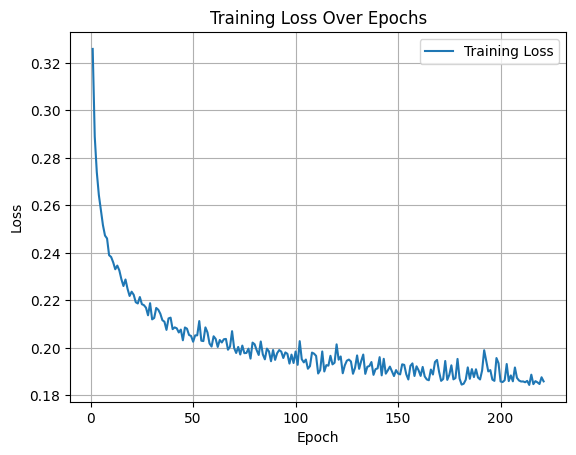

In [23]:
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

- Save the model's parameters instead of the whole model

In [24]:
torch.save(model.state_dict(), 'MLP_model.pth')
print("Model saved successfully.")

Model saved successfully.


- Convert data into Tensor format
- Load the model for testing phase
- Use the saved model to evaluate the testing dataset

In [25]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model = MLPModel(
    input_dim=X_train_combined.shape[1],
    hidden_layers=best_params['hidden_layers'],
    dropout_rate=best_params['dropout_rate']
).to(device)

model.load_state_dict(torch.load('MLP_model.pth'))
model.eval()

with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor).item()

    test_predictions = (test_predictions > 0.5).float()

# print(f"Test Loss: {test_loss:.4f}", "\n")

/var/folders/dw/gqdjz0756k11zwysr92bpkvc0000gn/T/ipykernel_16150/1158255887.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('MLP_model.

- Include metrics tracking and accuracy to assess the model's performance
- Flatten the data into 1D array
- Set a threshold prediction for confusion matrix

In [26]:
correct_predictions = (test_predictions == y_test_tensor).sum().item()
total_predictions = y_test_tensor.size(0)
accuracy = (correct_predictions / total_predictions) * 100

print(f"Test Loss: {test_loss:.4f}", "\n")
print(f"Accuracy: {accuracy:.2f}%", "\n")

# y_test_np = y_test_tensor.cpu().numpy().flatten()
# y_pred_np = test_predictions.cpu().numpy().flatten()
y_test_np = y_test_tensor.numpy().flatten()
y_pred_np = test_predictions.numpy().flatten()

binary_predictions = (y_pred_np > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test_np, y_pred_np), "\n")

# print("Confusion Matrix:")
# print(confusion_matrix(y_test_np, y_pred_np))

Test Loss: 0.2284 

Accuracy: 91.52% 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      8380
         1.0       0.51      0.39      0.44       792

    accuracy                           0.92      9172
   macro avg       0.73      0.68      0.70      9172
weighted avg       0.91      0.92      0.91      9172
 



- Plot a confusion matrix

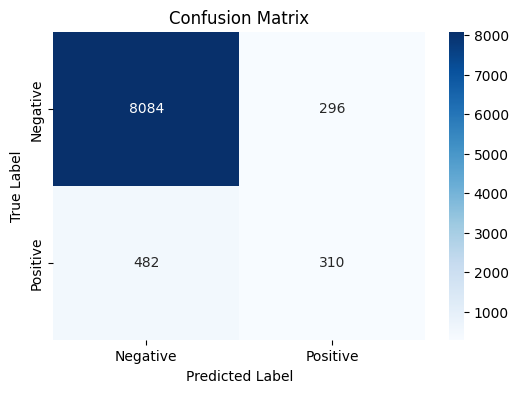

In [27]:
conf_matrix = confusion_matrix(y_test_np, binary_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

- Plot a precision-recall curve

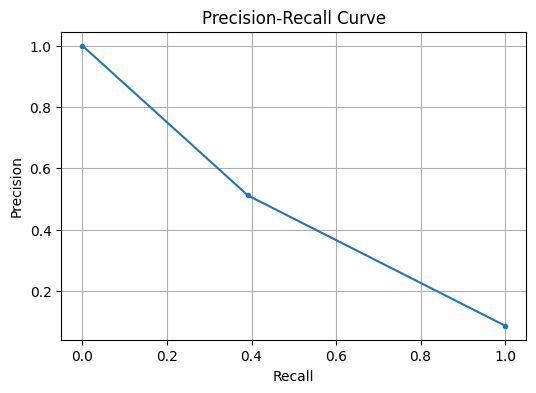

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test_np, y_pred_np)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

- Plot a ROC Curve

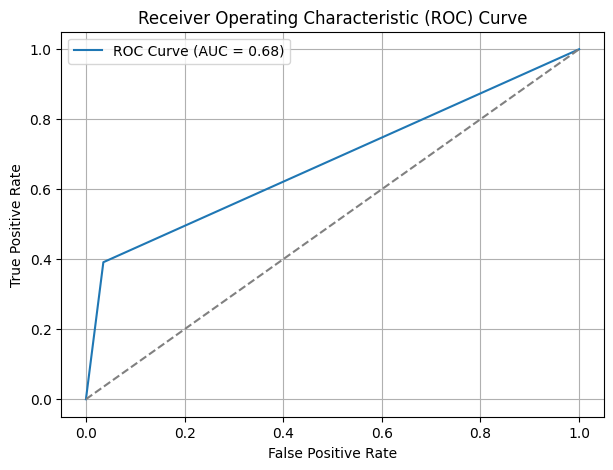

In [29]:
fpr, tpr, roc_thresholds = roc_curve(y_test_np, y_pred_np)
roc_auc = roc_auc_score(y_test_np, y_pred_np)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(True)
plt.show()